<a href="https://colab.research.google.com/github/mahshadmoradi/Machine-Learning/blob/main/Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [ ]:
# Set your student number
student_number = 400109373
Name = 'Mahshad'
Last_Name = 'Moradi'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**.
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [ ]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt

In [ ]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

100%|██████████| 26421880/26421880 [00:05<00:00, 4962121.07it/s] 


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 304212.91it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4029333.83it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12423634.63it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



### Data Exploration
Let's take a look at the classes in our dataset.

In [ ]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

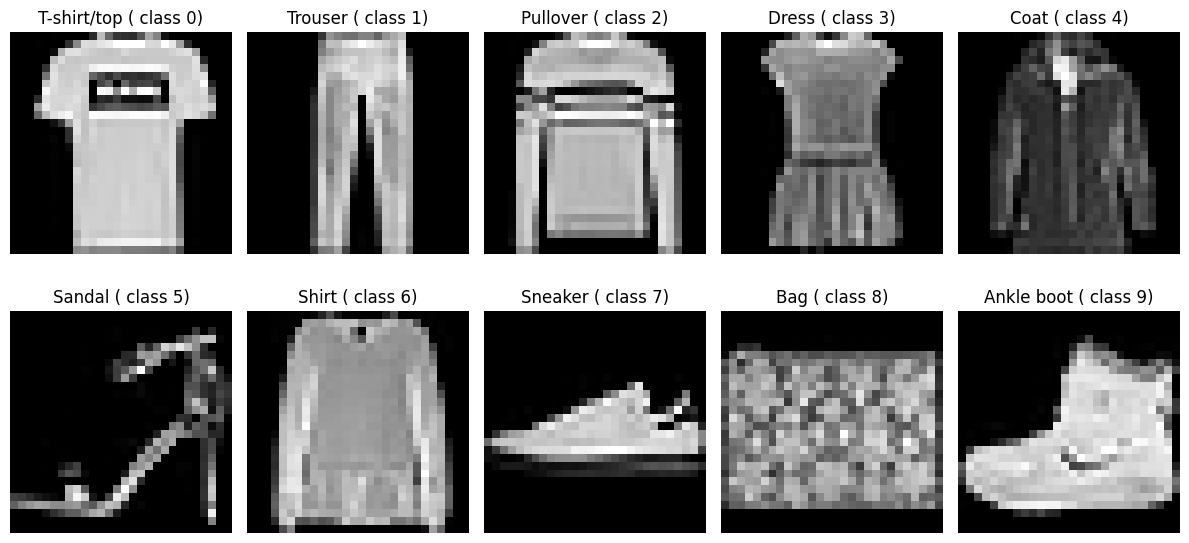

In [ ]:
######################
#   YOUR CODE HERE   #
######################

images_per_class = {} # Dictionary to store one image per class

# Iterate over the dataset to collect one image per class
for image, label in dataset:
    if label not in images_per_class:
        images_per_class[label] = image
    if len(images_per_class) == len(dataset.classes):
        break

# Sort the images by label
sorted_images = sorted(images_per_class.items())

# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

class_names = dataset.classes

for idx, (label, image) in enumerate(sorted_images):
    ax = axes[idx]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'{class_names[label]} ( class {label})')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.

In [ ]:
import numpy as np

def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [ ]:
######################
#   YOUR CODE HERE   #
######################
val_frac = 0.2 ## Set the fraction for the validation set
rand_seed = 42 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("number of samples in training set: {}".format(len(train_indices)))
print("number of samples in validation set: {}".format(len(val_indices)))

number of samples in training set: 48000
number of samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide.

In [ ]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [ ]:
######################
#   YOUR CODE HERE   #
######################
batch_size = 64 ## Set the batch size

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

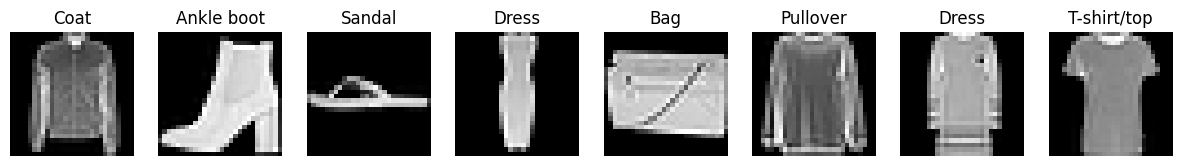

In [ ]:
######################
#   YOUR CODE HERE   #
######################

def plot_sample_images(data_loader, class_names, batch_size=8):
    # Get a batch of data
    images, labels = next(iter(data_loader))

    # Plot the images in the batch
    fig, axes = plt.subplots(1, batch_size, figsize=(15, 15))
    for i in range(batch_size):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(class_names[labels[i]])
        ax.axis('off')

    plt.show()

# Class names for FashionMNIST
class_names = dataset.classes

# Plot a sample batch of images
plot_sample_images(train_dl, class_names, batch_size=8)

### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [ ]:
!pip install torchinfo

In [ ]:
# Import required packages
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [ ]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1):
        super(ImageClassifierNet, self).__init__()
        ######################
        #   YOUR CODE HERE   #
        ######################
        self.conv1 = nn.Conv2d(n_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # based on the output size after pooling
        self.fc2 = nn.Linear(256, 10)

    def forward(self, X):
        ######################
        #   YOUR CODE HERE   #
        ######################
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = X.view(-1, 128 * 3 * 3)  # Flatten the tensor
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return X

In [33]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [ ]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─MaxPool2d: 1-2                         [64, 32, 14, 14]          --
├─Conv2d: 1-3                            [64, 64, 14, 14]          18,496
├─MaxPool2d: 1-4                         [64, 64, 7, 7]            --
├─Conv2d: 1-5                            [64, 128, 7, 7]           73,856
├─MaxPool2d: 1-6                         [64, 128, 3, 3]           --
├─Linear: 1-7                            [64, 256]                 295,168
├─Linear: 1-8                            [64, 10]                  2,570
Total params: 390,410
Trainable params: 390,410
Non-trainable params: 0
Total mult-adds (M): 498.74
Input size (MB): 0.20
Forward/backward pass size (MB): 22.62
Params size (MB): 1.56
Estimated Total Size (MB): 24.38

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [28]:
import torch

def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate

    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    ######################
    #   YOUR CODE HERE   #
    ######################
    optimizer = opt_fn(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_train_loss / len(train_dl))
        train_accuracies.append(correct_train / total_train)

        if len(val_dl) != 0 :
            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for images, labels in val_dl:
                  outputs = model(images)
                  loss = loss_fn(outputs, labels)
                  running_val_loss += loss.item()
                  _, predicted = torch.max(outputs.data, 1)
                  total_val += labels.size(0)
                  correct_val += (predicted == labels).sum().item()

            val_losses.append(running_val_loss / len(val_dl))
            val_accuracies.append(correct_val / total_val)

            print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')
        else :
            print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
######################
#   YOUR CODE HERE   #
######################
import torch.optim as optim

num_epochs = 10  # Number of training epochs
loss_fn = nn.CrossEntropyLoss()  # Define the loss function
opt_fn = optim.Adam  # Select an optimizer
lr = 0.001  # Set the learning rate

In [ ]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

Epoch [1/10], Train Loss: 0.4801, Train Accuracy: 0.8253, Val Loss: 0.3215, Val Accuracy: 0.8782
Epoch [2/10], Train Loss: 0.2893, Train Accuracy: 0.8932, Val Loss: 0.2677, Val Accuracy: 0.9027
Epoch [3/10], Train Loss: 0.2452, Train Accuracy: 0.9100, Val Loss: 0.2577, Val Accuracy: 0.9023
Epoch [4/10], Train Loss: 0.2131, Train Accuracy: 0.9207, Val Loss: 0.2517, Val Accuracy: 0.9095
Epoch [5/10], Train Loss: 0.1884, Train Accuracy: 0.9304, Val Loss: 0.2361, Val Accuracy: 0.9127
Epoch [6/10], Train Loss: 0.1651, Train Accuracy: 0.9381, Val Loss: 0.2472, Val Accuracy: 0.9150
Epoch [7/10], Train Loss: 0.1428, Train Accuracy: 0.9466, Val Loss: 0.2498, Val Accuracy: 0.9087
Epoch [8/10], Train Loss: 0.1250, Train Accuracy: 0.9543, Val Loss: 0.2407, Val Accuracy: 0.9166
Epoch [9/10], Train Loss: 0.1066, Train Accuracy: 0.9590, Val Loss: 0.2487, Val Accuracy: 0.9170
Epoch [10/10], Train Loss: 0.0916, Train Accuracy: 0.9644, Val Loss: 0.2712, Val Accuracy: 0.9214


### Plot loss and accuracy

In [ ]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

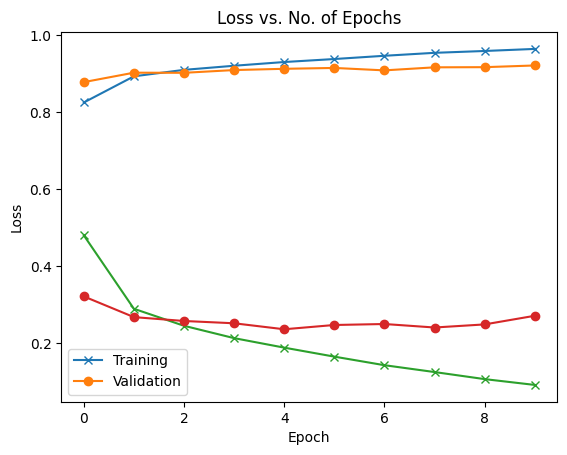

In [ ]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [ ]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)

In [31]:
######################
#   YOUR CODE HERE   #
######################
num_epochs = 10 # Max number of training epochs
lr = 0.001 # Set the learning rate

In [34]:
model, _, _, _, _ = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)

Epoch [1/10], Train Loss: 0.4531, Train Accuracy: 0.8320
Epoch [2/10], Train Loss: 0.2738, Train Accuracy: 0.9006
Epoch [3/10], Train Loss: 0.2283, Train Accuracy: 0.9150
Epoch [4/10], Train Loss: 0.1989, Train Accuracy: 0.9256
Epoch [5/10], Train Loss: 0.1738, Train Accuracy: 0.9352
Epoch [6/10], Train Loss: 0.1490, Train Accuracy: 0.9442
Epoch [7/10], Train Loss: 0.1292, Train Accuracy: 0.9505
Epoch [8/10], Train Loss: 0.1117, Train Accuracy: 0.9579
Epoch [9/10], Train Loss: 0.0941, Train Accuracy: 0.9641
Epoch [10/10], Train Loss: 0.0816, Train Accuracy: 0.9684


### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

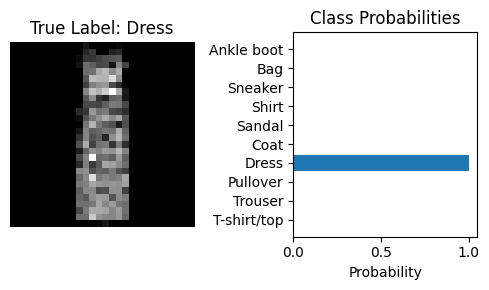

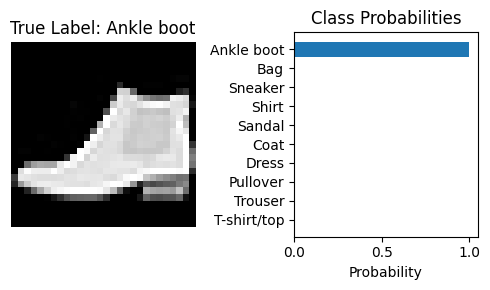

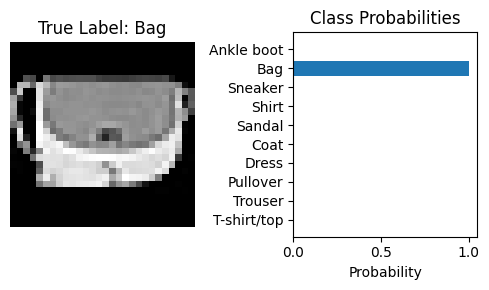

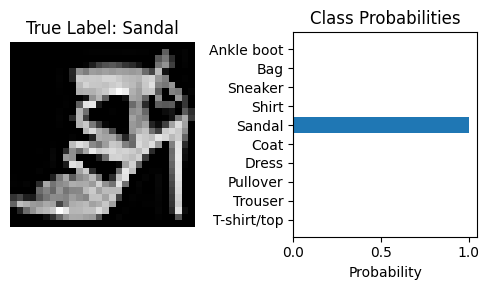

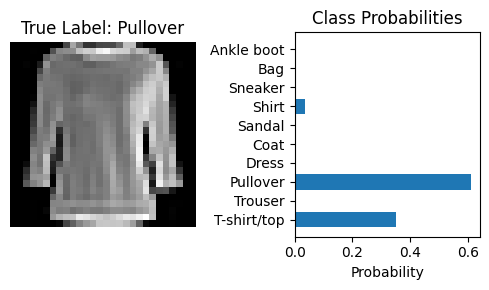

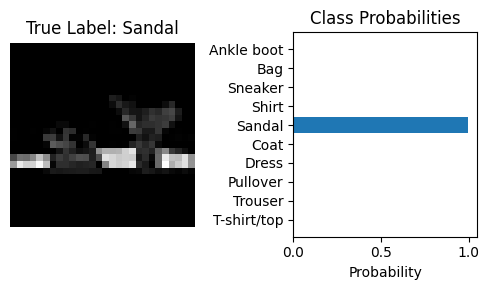

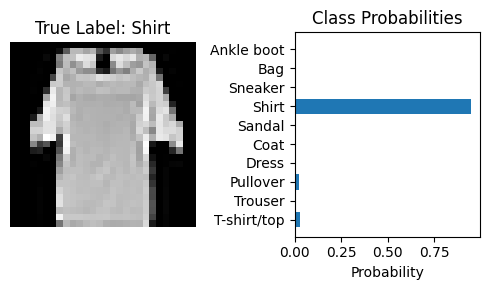

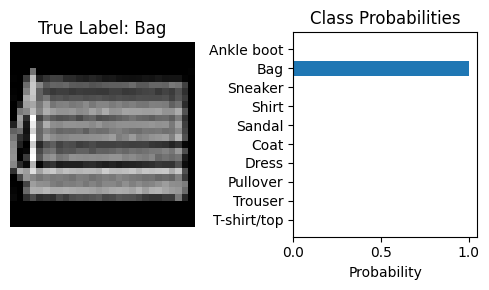

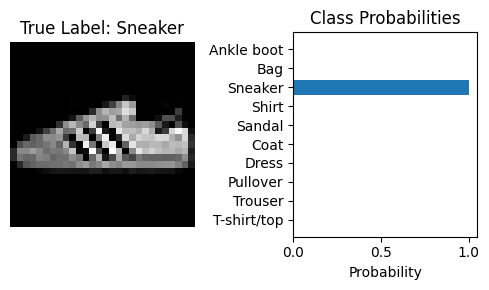

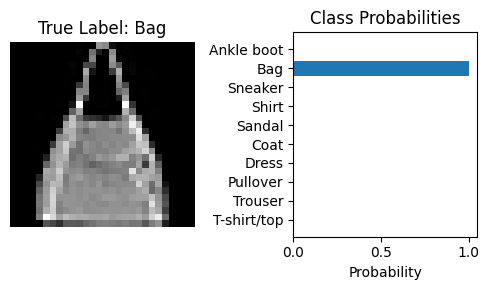

In [42]:
######################
#   YOUR CODE HERE   #
######################
def view_prediction(image, label, probabilities, class_names):

    plt.figure(figsize=(5, 3))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'True Label: {class_names[label]}')
    plt.axis('off')

    # Plot the probabilities
    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(class_names))
    plt.barh(y_pos, probabilities, align='center')
    plt.yticks(y_pos, class_names)
    plt.xlabel('Probability')
    plt.title('Class Probabilities')

    plt.tight_layout()
    plt.show()


def evaluate_and_visualize(model, test_dl, class_names):

    model.eval()
    images, labels = next(iter(test_dl))
    outputs = model(images)
    probabilities = torch.softmax(outputs, dim=1).detach().numpy()

    # Visualize the first 10 samples
    for i in range(10):
        view_prediction(images[i], labels[i], probabilities[i], class_names)

class_names = dataset.classes
evaluate_and_visualize(model, dl, class_names)

### Save the model

In [43]:
torch.save(model, 'model')

### Calculate accuracy on the test set

In [44]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

In [46]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.

    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader

    Returns:
        Test accuracy.
    """
    ######################
    #   YOUR CODE HERE   #
    ######################
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dl:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [47]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

Test Accuracy = 0.9193
